In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [62]:
behavior = pd.read_json('data/behavior.json')
cardata = pd.read_csv('data/cardata.csv', sep=";")
cardata = cardata[cardata.VRAAGPRIJS > 1] # prices below 1 can be seen as a flaw, but arbitrary value

# 1. Exploration 

### Contents of behavior.json
- consisting of 1) ID for each entry (unique values) and the components 2) contactrequests / 3) pageviews

In [63]:
behavior.head()

,AUTO_ID,contactrequests,pageviews
0,30062944,1,6
1,30079387,0,14
2,30100751,0,29
3,30119230,0,5
4,30167129,0,4


### Contents of cardata.csv

- consisting a unique id per entry and details regarding the price, kilometers, brand etc.

In [64]:
cardata.head()

,AUTO_ID,MERK,BOUWJAAR,KILOMETER_STAND,VRAAGPRIJS,EXTERIEUR_KLEUR,BRANDSTOF,CARROSSERIEVORM,MODEL
0,30017245,RENAULT,2011,53518.0,5744,GRIJS,DIESEL,HATCHBACK,CLIO
1,30017429,PORSCHE,2007,90210.0,79495,WIT,BENZINE,COUPE,911
2,30019197,LANCIA,1998,242363.0,5750,GRIJS,BENZINE,COUPE,KAPPA
3,30019768,PEUGEOT,2014,41812.0,13950,BRUIN,BENZINE,HATCHBACK,308
4,30022011,OPEL,2012,60902.0,10770,GRIJS,BENZINE,MPV,MERIVA


# 2. Adjustment

- cardata barely has any missing values, thus the missing values are left out of the dataset. The outliers remain within the dataset - the performance doesn't become better because of this, but from a business perspective it makes more sense to keep outliers in the dataset - you'll still want to predict a value for a Ferrari F-150, even though it rarely occurs within your data.

In [65]:
print(f'cardata length before dropping NaN: {len(cardata)}')
cardata = cardata.dropna()
print(f'cardata length after dropping NaN: {len(cardata)}')

cardata length before dropping NaN: 9964
cardata length after dropping NaN: 9928


### Bouwjaar into leeftijd

- from a regression perspective, translating the Year of Built (YoB) into the age of a car. Thus, a new column is made which subtracts the YoB from the current year (2021) and then drops the column of BOUWJAAR.

In [66]:
cardata['LEEFTIJD'] = 2021 - cardata.BOUWJAAR
cardata = cardata.drop(['BOUWJAAR'], axis = 1)
cardata.sample(5)

,AUTO_ID,MERK,KILOMETER_STAND,VRAAGPRIJS,EXTERIEUR_KLEUR,BRANDSTOF,CARROSSERIEVORM,MODEL,LEEFTIJD
6642,47350595,BMW,89162.0,74750,ZWART,BENZINE,SUV,X5,6
4003,45676184,PEUGEOT,213458.0,1650,GRIJS,BENZINE,HATCHBACK,206,22
3886,45570151,PEUGEOT,90388.0,6999,GRIJS,BENZINE,OVERIG,207,9
6914,47490927,DODGE,257620.0,21950,ZWART,BENZINE,SEDAN,CHARGER,13
5922,46988434,FORD,21146.0,29750,ZILVER,BENZINE,MPV,S-MAX,3


In [67]:
cardata.isnull().sum() #sanity check

AUTO_ID            0
MERK               0
KILOMETER_STAND    0
VRAAGPRIJS         0
EXTERIEUR_KLEUR    0
BRANDSTOF          0
CARROSSERIEVORM    0
MODEL              0
LEEFTIJD           0
dtype: int64

In [68]:
behavior.isnull().sum()

AUTO_ID            0
contactrequests    0
pageviews          0
dtype: int64

### Merge

- The datasets are merged by an inner join (only join on those ID's apparent in both df's, drop the others) since there are row's in each df that are not apparent in the other. Secondly, the ID's are dropped since they are not of use during the process of developing a model.

In [69]:
joined_cardata = cardata.join(behavior.set_index('AUTO_ID'), on='AUTO_ID', how= 'inner')
joined_cardata = joined_cardata.drop(['AUTO_ID'], axis=1)
joined_cardata.sample(5)

,MERK,KILOMETER_STAND,VRAAGPRIJS,EXTERIEUR_KLEUR,BRANDSTOF,CARROSSERIEVORM,MODEL,LEEFTIJD,contactrequests,pageviews
2995,MERCEDES-BENZ,87994.0,21949,GRIJS,BENZINE,CABRIOLET,SLK,10,0,4
8905,PEUGEOT,1.0,55950,GRIJS,BENZINE / ELEKTRICITEIT,STATIONWAGEN,508,0,0,1
6829,CITROEN,36718.0,20350,ZWART,BENZINE,MPV,C4 SPACETOURER,3,0,1
3047,FORD,97905.0,7900,BRUIN,BENZINE,MPV,B-MAX,8,0,1
3332,VOLVO,274275.0,1395,BLAUW,BENZINE,SEDAN,S60,20,0,3


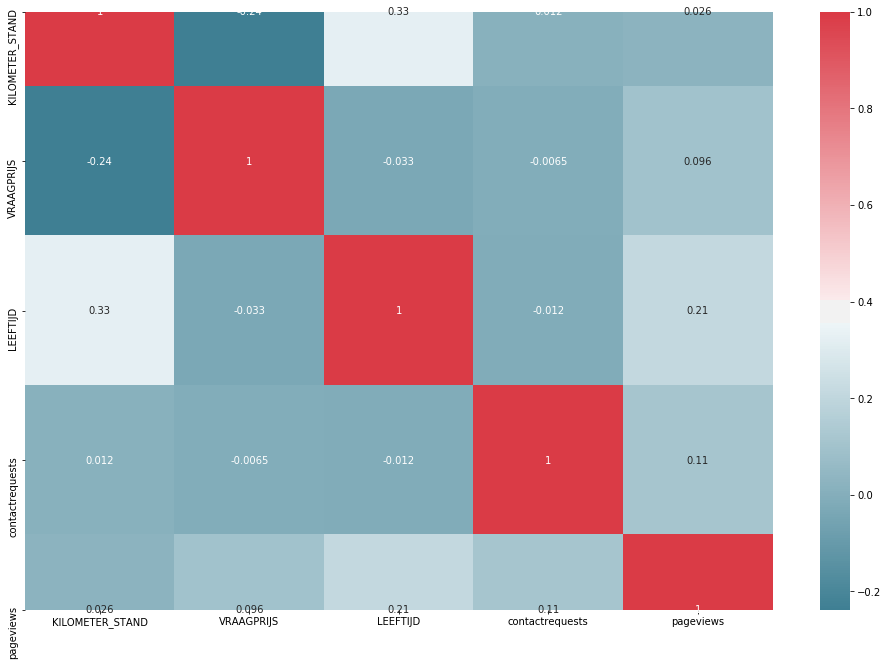

In [70]:
f, ax = plt.subplots(figsize=(17, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(data=joined_cardata.corr(),cmap=cmap,square=True,annot=True)
plt.show()



# 3. Model development

### pageviews
- Based on the heatmap above, we can see some multi-colinearity, but not that much that we have to tackle it initially. If it occurs later on, perhaps a PCA could provide a solution - however this will mean that the model becomes less transparent. I started off by doing a LR, however it wasn't learning at all (really large $R^2$). Based on this, I experimented with a regularized LR (like LassoCV / RidgeCV) but neither of those was learning either. Based on this, we can assume that the features don't really mean something to the target variable. However, I wanted to learn about XGBoost (ensembling technique, thus I experimented with it's components). It looks cool, but same here - the features won't do anything, plus hyper parameter optimization won't solve this.

In [71]:
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from sklearn.metrics import r2_score

In [72]:
y = joined_cardata['pageviews'].copy()
X = joined_cardata.drop(['contactrequests', 'pageviews'], axis=1).copy()

In [73]:
X_cats = X.select_dtypes(include=['object']) #all cats
car_dummies = pd.get_dummies(X_cats, drop_first=True) #convert to dummies

X = X.drop(list(X_cats.columns), axis=1)

X = pd.concat([X, car_dummies], axis=1)

columns=list(X.columns)

In [74]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=20)

In [76]:
params = {'learning_rate': [0.10, 0.15],
         'gamma':[0.0, 0.1],
         'max_depth': [3, 5, 7],
          'n_estimators' : [15,20]
        }

fit_params={"early_stopping_rounds":15, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_test, y_test]]}

regressor = xgb.XGBRegressor()

gs = GridSearchCV(estimator= regressor, param_grid= params, cv= 5, verbose= 0)

gs.fit(X_train, y_train, **fit_params)

[0]	validation_0-rmse:4.16859
[1]	validation_0-rmse:4.01877
[2]	validation_0-rmse:3.89053
[3]	validation_0-rmse:3.78316
[4]	validation_0-rmse:3.69359
[5]	validation_0-rmse:3.62071
[6]	validation_0-rmse:3.55539
[7]	validation_0-rmse:3.50381
[8]	validation_0-rmse:3.46049
[9]	validation_0-rmse:3.42656
[10]	validation_0-rmse:3.40098
[11]	validation_0-rmse:3.38017
[12]	validation_0-rmse:3.36114
[13]	validation_0-rmse:3.34603
[14]	validation_0-rmse:3.33464
[0]	validation_0-rmse:4.18931
[1]	validation_0-rmse:4.05933
[2]	validation_0-rmse:3.95260
[3]	validation_0-rmse:3.86216
[4]	validation_0-rmse:3.78693
[5]	validation_0-rmse:3.72678
[6]	validation_0-rmse:3.67638
[7]	validation_0-rmse:3.63367
[8]	validation_0-rmse:3.59586
[9]	validation_0-rmse:3.56236
[10]	validation_0-rmse:3.53990
[11]	validation_0-rmse:3.50992
[12]	validation_0-rmse:3.48404
[13]	validation_0-rmse:3.47447
[14]	validation_0-rmse:3.45074
[0]	validation_0-rmse:4.18248
[1]	validation_0-rmse:4.05416
[2]	validation_0-rmse:3.94480


[0]	validation_0-rmse:4.18948
[1]	validation_0-rmse:4.05972
[2]	validation_0-rmse:3.95391
[3]	validation_0-rmse:3.86088
[4]	validation_0-rmse:3.78831
[5]	validation_0-rmse:3.72276
[6]	validation_0-rmse:3.67415
[7]	validation_0-rmse:3.63204
[8]	validation_0-rmse:3.59351
[9]	validation_0-rmse:3.56415
[10]	validation_0-rmse:3.53913
[11]	validation_0-rmse:3.52401
[12]	validation_0-rmse:3.51043
[13]	validation_0-rmse:3.49656
[14]	validation_0-rmse:3.48147
[15]	validation_0-rmse:3.46811
[16]	validation_0-rmse:3.46265
[17]	validation_0-rmse:3.45472
[18]	validation_0-rmse:3.45250
[19]	validation_0-rmse:3.44042
[0]	validation_0-rmse:4.19063
[1]	validation_0-rmse:4.04587
[2]	validation_0-rmse:3.92990
[3]	validation_0-rmse:3.84113
[4]	validation_0-rmse:3.76378
[5]	validation_0-rmse:3.70313
[6]	validation_0-rmse:3.65214
[7]	validation_0-rmse:3.60810
[8]	validation_0-rmse:3.57209
[9]	validation_0-rmse:3.54457
[10]	validation_0-rmse:3.51369
[11]	validation_0-rmse:3.49103
[12]	validation_0-rmse:3.471

[0]	validation_0-rmse:4.11593
[1]	validation_0-rmse:3.94352
[2]	validation_0-rmse:3.81701
[3]	validation_0-rmse:3.72259
[4]	validation_0-rmse:3.64983
[5]	validation_0-rmse:3.59552
[6]	validation_0-rmse:3.53622
[7]	validation_0-rmse:3.50197
[8]	validation_0-rmse:3.45580
[9]	validation_0-rmse:3.44337
[10]	validation_0-rmse:3.42250
[11]	validation_0-rmse:3.41323
[12]	validation_0-rmse:3.40139
[13]	validation_0-rmse:3.40351
[14]	validation_0-rmse:3.39948
[0]	validation_0-rmse:4.10624
[1]	validation_0-rmse:3.93513
[2]	validation_0-rmse:3.80267
[3]	validation_0-rmse:3.70321
[4]	validation_0-rmse:3.62486
[5]	validation_0-rmse:3.56411
[6]	validation_0-rmse:3.51901
[7]	validation_0-rmse:3.48563
[8]	validation_0-rmse:3.45872
[9]	validation_0-rmse:3.43756
[10]	validation_0-rmse:3.41529
[11]	validation_0-rmse:3.40380
[12]	validation_0-rmse:3.38189
[13]	validation_0-rmse:3.37990
[14]	validation_0-rmse:3.36482
[0]	validation_0-rmse:4.08470
[1]	validation_0-rmse:3.89920
[2]	validation_0-rmse:3.76691


[15]	validation_0-rmse:3.43344
[16]	validation_0-rmse:3.43812
[17]	validation_0-rmse:3.42233
[18]	validation_0-rmse:3.42060
[19]	validation_0-rmse:3.41956
[0]	validation_0-rmse:4.11852
[1]	validation_0-rmse:3.92458
[2]	validation_0-rmse:3.79420
[3]	validation_0-rmse:3.69001
[4]	validation_0-rmse:3.62133
[5]	validation_0-rmse:3.56656
[6]	validation_0-rmse:3.52582
[7]	validation_0-rmse:3.48628
[8]	validation_0-rmse:3.46168
[9]	validation_0-rmse:3.43874
[10]	validation_0-rmse:3.42120
[11]	validation_0-rmse:3.41092
[12]	validation_0-rmse:3.39418
[13]	validation_0-rmse:3.38647
[14]	validation_0-rmse:3.36155
[15]	validation_0-rmse:3.34957
[16]	validation_0-rmse:3.34697
[17]	validation_0-rmse:3.33458
[18]	validation_0-rmse:3.32723
[19]	validation_0-rmse:3.32448
[0]	validation_0-rmse:4.09064
[1]	validation_0-rmse:3.88720
[2]	validation_0-rmse:3.73012
[3]	validation_0-rmse:3.61312
[4]	validation_0-rmse:3.52896
[5]	validation_0-rmse:3.47159
[6]	validation_0-rmse:3.42217
[7]	validation_0-rmse:3.3

[0]	validation_0-rmse:4.18248
[1]	validation_0-rmse:4.05416
[2]	validation_0-rmse:3.94480
[3]	validation_0-rmse:3.85354
[4]	validation_0-rmse:3.77721
[5]	validation_0-rmse:3.71126
[6]	validation_0-rmse:3.65638
[7]	validation_0-rmse:3.61065
[8]	validation_0-rmse:3.57229
[9]	validation_0-rmse:3.53645
[10]	validation_0-rmse:3.50981
[11]	validation_0-rmse:3.48906
[12]	validation_0-rmse:3.46922
[13]	validation_0-rmse:3.45415
[14]	validation_0-rmse:3.43766
[0]	validation_0-rmse:4.16886
[1]	validation_0-rmse:4.03085
[2]	validation_0-rmse:3.92293
[3]	validation_0-rmse:3.81236
[4]	validation_0-rmse:3.73612
[5]	validation_0-rmse:3.67363
[6]	validation_0-rmse:3.61992
[7]	validation_0-rmse:3.57374
[8]	validation_0-rmse:3.53562
[9]	validation_0-rmse:3.50571
[10]	validation_0-rmse:3.48128
[11]	validation_0-rmse:3.45784
[12]	validation_0-rmse:3.44141
[13]	validation_0-rmse:3.42514
[14]	validation_0-rmse:3.41441
[0]	validation_0-rmse:4.19540
[1]	validation_0-rmse:4.05713
[2]	validation_0-rmse:3.95330


[10]	validation_0-rmse:3.51369
[11]	validation_0-rmse:3.49103
[12]	validation_0-rmse:3.47153
[13]	validation_0-rmse:3.45729
[14]	validation_0-rmse:3.44486
[15]	validation_0-rmse:3.43063
[16]	validation_0-rmse:3.41635
[17]	validation_0-rmse:3.40869
[18]	validation_0-rmse:3.40086
[19]	validation_0-rmse:3.39400
[0]	validation_0-rmse:4.17276
[1]	validation_0-rmse:4.02267
[2]	validation_0-rmse:3.89469
[3]	validation_0-rmse:3.80439
[4]	validation_0-rmse:3.70948
[5]	validation_0-rmse:3.63177
[6]	validation_0-rmse:3.57733
[7]	validation_0-rmse:3.53108
[8]	validation_0-rmse:3.49143
[9]	validation_0-rmse:3.46062
[10]	validation_0-rmse:3.43614
[11]	validation_0-rmse:3.41253
[12]	validation_0-rmse:3.39059
[13]	validation_0-rmse:3.37455
[14]	validation_0-rmse:3.36225
[15]	validation_0-rmse:3.35327
[16]	validation_0-rmse:3.34355
[17]	validation_0-rmse:3.33493
[18]	validation_0-rmse:3.32782
[19]	validation_0-rmse:3.32300
[0]	validation_0-rmse:4.18747
[1]	validation_0-rmse:4.05255
[2]	validation_0-rms

[0]	validation_0-rmse:4.08470
[1]	validation_0-rmse:3.89920
[2]	validation_0-rmse:3.76691
[3]	validation_0-rmse:3.66696
[4]	validation_0-rmse:3.59025
[5]	validation_0-rmse:3.53095
[6]	validation_0-rmse:3.48887
[7]	validation_0-rmse:3.45317
[8]	validation_0-rmse:3.43001
[9]	validation_0-rmse:3.41087
[10]	validation_0-rmse:3.39631
[11]	validation_0-rmse:3.38902
[12]	validation_0-rmse:3.37683
[13]	validation_0-rmse:3.37447
[14]	validation_0-rmse:3.36824
[0]	validation_0-rmse:4.12473
[1]	validation_0-rmse:3.93918
[2]	validation_0-rmse:3.78457
[3]	validation_0-rmse:3.68989
[4]	validation_0-rmse:3.60337
[5]	validation_0-rmse:3.54265
[6]	validation_0-rmse:3.50383
[7]	validation_0-rmse:3.47103
[8]	validation_0-rmse:3.45157
[9]	validation_0-rmse:3.43373
[10]	validation_0-rmse:3.40802
[11]	validation_0-rmse:3.39281
[12]	validation_0-rmse:3.38682
[13]	validation_0-rmse:3.37219
[14]	validation_0-rmse:3.36623
[0]	validation_0-rmse:4.08458
[1]	validation_0-rmse:3.88245
[2]	validation_0-rmse:3.72486


[5]	validation_0-rmse:3.47159
[6]	validation_0-rmse:3.42217
[7]	validation_0-rmse:3.39174
[8]	validation_0-rmse:3.36220
[9]	validation_0-rmse:3.34406
[10]	validation_0-rmse:3.32319
[11]	validation_0-rmse:3.31362
[12]	validation_0-rmse:3.30291
[13]	validation_0-rmse:3.29587
[14]	validation_0-rmse:3.29066
[15]	validation_0-rmse:3.28613
[16]	validation_0-rmse:3.28418
[17]	validation_0-rmse:3.27768
[18]	validation_0-rmse:3.26791
[19]	validation_0-rmse:3.26884
[0]	validation_0-rmse:4.11264
[1]	validation_0-rmse:3.93062
[2]	validation_0-rmse:3.79209
[3]	validation_0-rmse:3.68133
[4]	validation_0-rmse:3.59091
[5]	validation_0-rmse:3.54455
[6]	validation_0-rmse:3.49557
[7]	validation_0-rmse:3.46199
[8]	validation_0-rmse:3.43327
[9]	validation_0-rmse:3.41576
[10]	validation_0-rmse:3.40094
[11]	validation_0-rmse:3.38120
[12]	validation_0-rmse:3.37013
[13]	validation_0-rmse:3.35944
[14]	validation_0-rmse:3.35848
[15]	validation_0-rmse:3.35908
[16]	validation_0-rmse:3.35188
[17]	validation_0-rmse:

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

In [120]:
print(gs.best_params_)

{'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 15}


In [125]:
xgr_p = xgb.XGBRegressor(eta=0.15,max_depth=3,n_estimators=20, gamma=0.0)

xgr_p.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.15, gamma=0.0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.150000006, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [126]:
y_true = np.array(y_test, dtype=np.float)
y_pred = np.array(xgr_p.predict(X_test), dtype=np.float)

In [127]:
print("R^2 Score: {:.4f}".format(r2_score(y_true, y_pred)))

R^2 Score: 0.0004


In [128]:
t_true = np.array(y_train, dtype=np.float)
t_pred = np.array(xgr_p.predict(X_train), dtype=np.float) # check whether a model can predict our training set 

In [129]:
print("R^2 Score: {:.4f}".format(r2_score(t_true, t_pred))) #sanity-check for overfitting

R^2 Score: 0.4565


In [130]:
feature_important = xgr_p.get_booster().get_score(importance_type='weight')

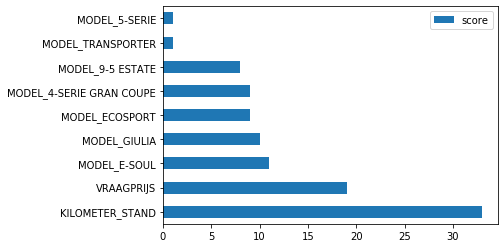

In [131]:
keys = [columns[int(i[1:])] for i in list(feature_important.keys())]
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

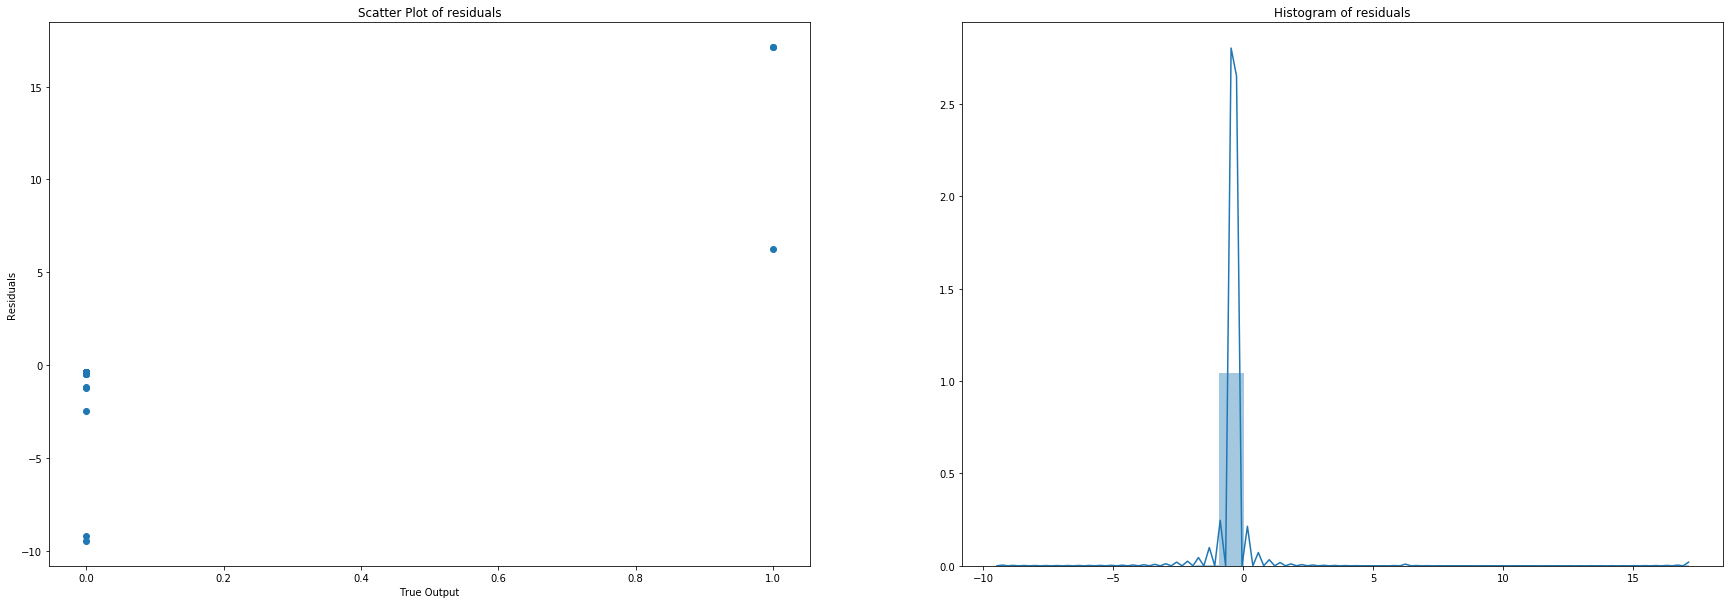

In [133]:
def residual_plot(y_test, y_pred):
    res = y_test - y_pred
    fig, axs = plt.subplots(1,2,figsize=(30,10))
    std_res = res/np.std(res)
    axs[0].title.set_text('Scatter Plot of residuals')
    axs[0].set_xlabel('True Output')
    axs[0].set_ylabel('Residuals')
    axs[0].scatter(y_test,std_res)
    axs[1].title.set_text('Histogram of residuals')
    sns.distplot(std_res, ax = axs[1]);
    plt.show()
    
residual_plot(y_true, y_pred)

### contact requests
- Initially we're looking for a regression prediction. Therefore the same approach is applied to this column initially to verify whether the features mean something to the target variable. Unfortunately, the same happens here, the model is just not able to converge at all. Adjusting parameters won't seal the deal. The model is using the numeric values primarily as coeffecients, but the correlation between the target and the picked features is minimal.

In [86]:
y = joined_cardata['contactrequests'].copy()
X = joined_cardata.drop(['contactrequests', 'pageviews'], axis=1).copy()

In [87]:
X_cats = X.select_dtypes(include=['object']) #all cats
car_dummies = pd.get_dummies(X_cats, drop_first=True) #convert to dummies

X = X.drop(list(X_cats.columns), axis=1)

X = pd.concat([X, car_dummies], axis=1)

columns=list(X.columns)

In [88]:
X = scaler.fit_transform(X)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=20)

In [90]:
params = {'learning_rate': [0.10, 0.15],
         'gamma':[0.0, 0.1],
         'max_depth': [3, 5, 7],
          'n_estimators' : [15,20]
        }

fit_params={"early_stopping_rounds":15, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_test, y_test]]}

regressor = xgb.XGBRegressor()

gs = GridSearchCV(estimator= regressor, param_grid= params, cv= 5, verbose= 0)

gs.fit(X_train, y_train, **fit_params)

[0]	validation_0-rmse:0.45066
[1]	validation_0-rmse:0.40637
[2]	validation_0-rmse:0.36659
[3]	validation_0-rmse:0.33091
[4]	validation_0-rmse:0.29876
[5]	validation_0-rmse:0.27007
[6]	validation_0-rmse:0.24434
[7]	validation_0-rmse:0.22123
[8]	validation_0-rmse:0.20068
[9]	validation_0-rmse:0.18206
[10]	validation_0-rmse:0.16575
[11]	validation_0-rmse:0.15097
[12]	validation_0-rmse:0.13780
[13]	validation_0-rmse:0.12649
[14]	validation_0-rmse:0.11660
[0]	validation_0-rmse:0.45068
[1]	validation_0-rmse:0.40649
[2]	validation_0-rmse:0.36688
[3]	validation_0-rmse:0.33125
[4]	validation_0-rmse:0.29919
[5]	validation_0-rmse:0.27058
[6]	validation_0-rmse:0.24484
[7]	validation_0-rmse:0.22187
[8]	validation_0-rmse:0.20146
[9]	validation_0-rmse:0.18323
[10]	validation_0-rmse:0.16699
[11]	validation_0-rmse:0.15263
[12]	validation_0-rmse:0.13999
[13]	validation_0-rmse:0.12873
[14]	validation_0-rmse:0.11912
[0]	validation_0-rmse:0.45058
[1]	validation_0-rmse:0.40620
[2]	validation_0-rmse:0.36636


[0]	validation_0-rmse:0.45066
[1]	validation_0-rmse:0.40634
[2]	validation_0-rmse:0.36655
[3]	validation_0-rmse:0.33085
[4]	validation_0-rmse:0.29885
[5]	validation_0-rmse:0.27015
[6]	validation_0-rmse:0.24448
[7]	validation_0-rmse:0.22156
[8]	validation_0-rmse:0.20098
[9]	validation_0-rmse:0.18260
[10]	validation_0-rmse:0.16645
[11]	validation_0-rmse:0.15219
[12]	validation_0-rmse:0.13967
[13]	validation_0-rmse:0.12841
[14]	validation_0-rmse:0.11855
[15]	validation_0-rmse:0.11002
[16]	validation_0-rmse:0.10249
[17]	validation_0-rmse:0.09602
[18]	validation_0-rmse:0.09042
[19]	validation_0-rmse:0.08592
[0]	validation_0-rmse:0.45053
[1]	validation_0-rmse:0.40606
[2]	validation_0-rmse:0.36603
[3]	validation_0-rmse:0.33013
[4]	validation_0-rmse:0.29783
[5]	validation_0-rmse:0.26885
[6]	validation_0-rmse:0.24290
[7]	validation_0-rmse:0.21960
[8]	validation_0-rmse:0.19878
[9]	validation_0-rmse:0.18012
[10]	validation_0-rmse:0.16350
[11]	validation_0-rmse:0.14864
[12]	validation_0-rmse:0.135

[0]	validation_0-rmse:0.42605
[1]	validation_0-rmse:0.36357
[2]	validation_0-rmse:0.31074
[3]	validation_0-rmse:0.26612
[4]	validation_0-rmse:0.22847
[5]	validation_0-rmse:0.19665
[6]	validation_0-rmse:0.17002
[7]	validation_0-rmse:0.14797
[8]	validation_0-rmse:0.12975
[9]	validation_0-rmse:0.11500
[10]	validation_0-rmse:0.10296
[11]	validation_0-rmse:0.09295
[12]	validation_0-rmse:0.08575
[13]	validation_0-rmse:0.07978
[14]	validation_0-rmse:0.07489
[0]	validation_0-rmse:0.42590
[1]	validation_0-rmse:0.36312
[2]	validation_0-rmse:0.30997
[3]	validation_0-rmse:0.26499
[4]	validation_0-rmse:0.22702
[5]	validation_0-rmse:0.19502
[6]	validation_0-rmse:0.16817
[7]	validation_0-rmse:0.14574
[8]	validation_0-rmse:0.12703
[9]	validation_0-rmse:0.11177
[10]	validation_0-rmse:0.09875
[11]	validation_0-rmse:0.08861
[12]	validation_0-rmse:0.07997
[13]	validation_0-rmse:0.07353
[14]	validation_0-rmse:0.06806
[0]	validation_0-rmse:0.42626
[1]	validation_0-rmse:0.36382
[2]	validation_0-rmse:0.31096


[15]	validation_0-rmse:0.07316
[16]	validation_0-rmse:0.07066
[17]	validation_0-rmse:0.06878
[18]	validation_0-rmse:0.06747
[19]	validation_0-rmse:0.06650
[0]	validation_0-rmse:0.42582
[1]	validation_0-rmse:0.36289
[2]	validation_0-rmse:0.30947
[3]	validation_0-rmse:0.26424
[4]	validation_0-rmse:0.22609
[5]	validation_0-rmse:0.19382
[6]	validation_0-rmse:0.16675
[7]	validation_0-rmse:0.14400
[8]	validation_0-rmse:0.12493
[9]	validation_0-rmse:0.10920
[10]	validation_0-rmse:0.09638
[11]	validation_0-rmse:0.08595
[12]	validation_0-rmse:0.07743
[13]	validation_0-rmse:0.07065
[14]	validation_0-rmse:0.06546
[15]	validation_0-rmse:0.06149
[16]	validation_0-rmse:0.05836
[17]	validation_0-rmse:0.05599
[18]	validation_0-rmse:0.05435
[19]	validation_0-rmse:0.05307
[0]	validation_0-rmse:0.42623
[1]	validation_0-rmse:0.36381
[2]	validation_0-rmse:0.31110
[3]	validation_0-rmse:0.26664
[4]	validation_0-rmse:0.22935
[5]	validation_0-rmse:0.19796
[6]	validation_0-rmse:0.17177
[7]	validation_0-rmse:0.1

[0]	validation_0-rmse:0.45058
[1]	validation_0-rmse:0.40620
[2]	validation_0-rmse:0.36636
[3]	validation_0-rmse:0.33057
[4]	validation_0-rmse:0.29847
[5]	validation_0-rmse:0.26957
[6]	validation_0-rmse:0.24364
[7]	validation_0-rmse:0.22038
[8]	validation_0-rmse:0.19951
[9]	validation_0-rmse:0.18103
[10]	validation_0-rmse:0.16450
[11]	validation_0-rmse:0.14968
[12]	validation_0-rmse:0.13660
[13]	validation_0-rmse:0.12502
[14]	validation_0-rmse:0.11464
[0]	validation_0-rmse:0.45081
[1]	validation_0-rmse:0.40664
[2]	validation_0-rmse:0.36700
[3]	validation_0-rmse:0.33144
[4]	validation_0-rmse:0.29948
[5]	validation_0-rmse:0.27092
[6]	validation_0-rmse:0.24530
[7]	validation_0-rmse:0.22243
[8]	validation_0-rmse:0.20197
[9]	validation_0-rmse:0.18378
[10]	validation_0-rmse:0.16756
[11]	validation_0-rmse:0.15319
[12]	validation_0-rmse:0.14047
[13]	validation_0-rmse:0.12926
[14]	validation_0-rmse:0.11936
[0]	validation_0-rmse:0.45076
[1]	validation_0-rmse:0.40653
[2]	validation_0-rmse:0.36685


[10]	validation_0-rmse:0.16353
[11]	validation_0-rmse:0.14866
[12]	validation_0-rmse:0.13550
[13]	validation_0-rmse:0.12376
[14]	validation_0-rmse:0.11346
[15]	validation_0-rmse:0.10441
[16]	validation_0-rmse:0.09648
[17]	validation_0-rmse:0.08950
[18]	validation_0-rmse:0.08345
[19]	validation_0-rmse:0.07826
[0]	validation_0-rmse:0.45079
[1]	validation_0-rmse:0.40662
[2]	validation_0-rmse:0.36699
[3]	validation_0-rmse:0.33150
[4]	validation_0-rmse:0.29973
[5]	validation_0-rmse:0.27117
[6]	validation_0-rmse:0.24576
[7]	validation_0-rmse:0.22305
[8]	validation_0-rmse:0.20270
[9]	validation_0-rmse:0.18474
[10]	validation_0-rmse:0.16852
[11]	validation_0-rmse:0.15424
[12]	validation_0-rmse:0.14173
[13]	validation_0-rmse:0.13089
[14]	validation_0-rmse:0.12113
[15]	validation_0-rmse:0.11281
[16]	validation_0-rmse:0.10552
[17]	validation_0-rmse:0.09920
[18]	validation_0-rmse:0.09376
[19]	validation_0-rmse:0.08918
[0]	validation_0-rmse:0.45076
[1]	validation_0-rmse:0.40660
[2]	validation_0-rms

[0]	validation_0-rmse:0.42626
[1]	validation_0-rmse:0.36382
[2]	validation_0-rmse:0.31096
[3]	validation_0-rmse:0.26637
[4]	validation_0-rmse:0.22891
[5]	validation_0-rmse:0.19726
[6]	validation_0-rmse:0.17099
[7]	validation_0-rmse:0.14923
[8]	validation_0-rmse:0.13112
[9]	validation_0-rmse:0.11627
[10]	validation_0-rmse:0.10445
[11]	validation_0-rmse:0.09483
[12]	validation_0-rmse:0.08725
[13]	validation_0-rmse:0.08168
[14]	validation_0-rmse:0.07710
[0]	validation_0-rmse:0.42618
[1]	validation_0-rmse:0.36369
[2]	validation_0-rmse:0.31078
[3]	validation_0-rmse:0.26611
[4]	validation_0-rmse:0.22856
[5]	validation_0-rmse:0.19673
[6]	validation_0-rmse:0.17027
[7]	validation_0-rmse:0.14831
[8]	validation_0-rmse:0.13023
[9]	validation_0-rmse:0.11523
[10]	validation_0-rmse:0.10283
[11]	validation_0-rmse:0.09314
[12]	validation_0-rmse:0.08547
[13]	validation_0-rmse:0.07917
[14]	validation_0-rmse:0.07470
[0]	validation_0-rmse:0.42603
[1]	validation_0-rmse:0.36340
[2]	validation_0-rmse:0.31040


[5]	validation_0-rmse:0.19778
[6]	validation_0-rmse:0.17166
[7]	validation_0-rmse:0.15000
[8]	validation_0-rmse:0.13202
[9]	validation_0-rmse:0.11754
[10]	validation_0-rmse:0.10565
[11]	validation_0-rmse:0.09666
[12]	validation_0-rmse:0.08918
[13]	validation_0-rmse:0.08340
[14]	validation_0-rmse:0.07906
[15]	validation_0-rmse:0.07585
[16]	validation_0-rmse:0.07340
[17]	validation_0-rmse:0.07169
[18]	validation_0-rmse:0.07032
[19]	validation_0-rmse:0.06937
[0]	validation_0-rmse:0.42619
[1]	validation_0-rmse:0.36377
[2]	validation_0-rmse:0.31083
[3]	validation_0-rmse:0.26634
[4]	validation_0-rmse:0.22863
[5]	validation_0-rmse:0.19731
[6]	validation_0-rmse:0.17081
[7]	validation_0-rmse:0.14897
[8]	validation_0-rmse:0.13107
[9]	validation_0-rmse:0.11643
[10]	validation_0-rmse:0.10442
[11]	validation_0-rmse:0.09510
[12]	validation_0-rmse:0.08756
[13]	validation_0-rmse:0.08168
[14]	validation_0-rmse:0.07739
[15]	validation_0-rmse:0.07410
[16]	validation_0-rmse:0.07161
[17]	validation_0-rmse:

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

In [91]:
print(gs.best_params_)

{'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 20}


In [115]:
xgr_c = xgb.XGBRegressor(eta=0.15,max_depth=3,n_estimators=20, gamma=0.1)

xgr_c.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.15, gamma=0.1,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.150000006, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [116]:
y_true = np.array(y_test, dtype=np.float)
y_pred = np.array(xgr_c.predict(X_test), dtype=np.float)

In [117]:
print("R^2 Score: {:.4f}".format(r2_score(y_true, y_pred)))

R^2 Score: 0.0036


In [118]:
t_true = np.array(y_train, dtype=np.float)
t_pred = np.array(xgr_c.predict(X_train), dtype=np.float) # check whether a model can predict our training set 

print("R^2 Score: {:.4f}".format(r2_score(t_true, t_pred))) #sanity-check for overfitting

R^2 Score: 0.4170


In [119]:
feature_important = xgr_c.get_booster().get_score(importance_type='weight')

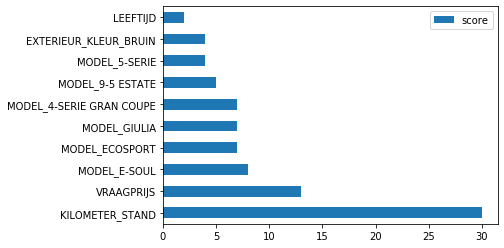

In [97]:
keys = [columns[int(i[1:])] for i in list(feature_important.keys())]
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

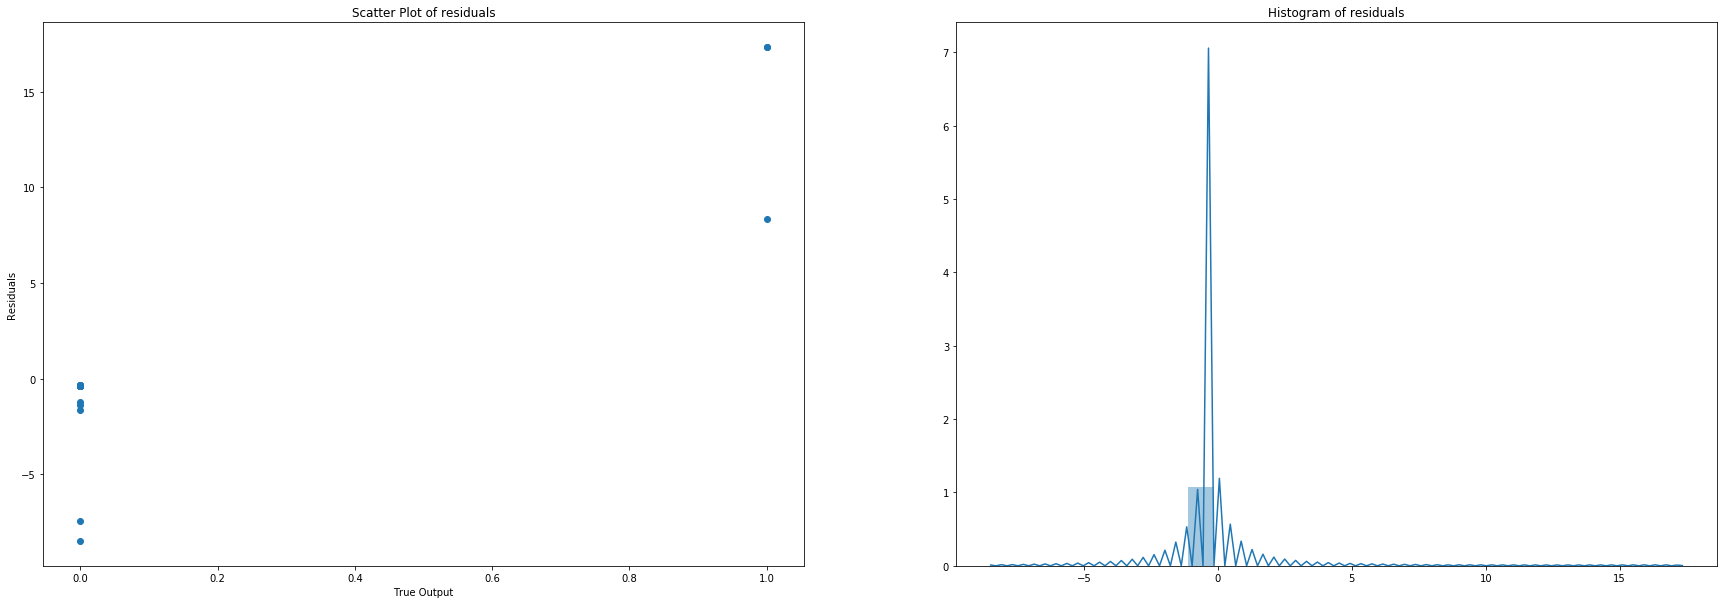

In [98]:
residual_plot(y_true, y_pred)

# But.. what if we make a classification out of it?

- Instead of predicting a continous variable, predict whether a car becomes contact requested or not? For instance, transform the contact requests into 0 being no contact request and 1 being at least 1 contact request. However, the fact that the data is heavily imbalanced, the models are just barely learning if we look at the produced tree of XGB. This is also visible in the gridsearch, it just outputs the same value for the metric.

In [99]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [100]:
classification_data = joined_cardata.copy()

In [101]:
classification_data.contactrequests.value_counts()

0    4095
1      13
2       1
Name: contactrequests, dtype: int64

In [102]:
classification_data['contactrequests'] = classification_data.contactrequests.apply(lambda x: x if (x < 1) else 1)

In [103]:
classification_data.contactrequests.value_counts() #sanity-check, but also shows imbalanced data thus different metrics

0    4095
1      14
Name: contactrequests, dtype: int64

In [104]:
y = classification_data['contactrequests'].copy()
X = classification_data.drop(['contactrequests', 'pageviews'], axis=1).copy()

In [105]:
X_cats = X.select_dtypes(include=['object']) #all cats
car_dummies = pd.get_dummies(X_cats, drop_first=True) #convert to dummies

X = X.drop(list(X_cats.columns), axis=1)

X = pd.concat([X, car_dummies], axis=1)

columns=list(X.columns)

In [106]:
X = scaler.fit_transform(X)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=20)

In [108]:
params = {'learning_rate': [0.10, 0.15],
         'gamma':[0.0, 0.1],
         'max_depth': [3, 5, 7],
          'n_estimators' : [15,20]
        }

fit_params={"early_stopping_rounds":15, 
            "eval_metric" : "error", 
            "eval_set" : [[X_test, y_test]]}

classifier = xgb.XGBClassifier(use_label_encoder=False)

gs = GridSearchCV(estimator= classifier, param_grid= params, verbose= False)

gs.fit(X_train, y_train, **fit_params)

[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.0036

[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.0036

[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[15]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.003

[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.0036

[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[15]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00

[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00

[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.00365
[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365
[0]	validation_0-error:0.003

[1]	validation_0-error:0.00365
[2]	validation_0-error:0.00365
[3]	validation_0-error:0.00365
[4]	validation_0-error:0.00365
[5]	validation_0-error:0.00365
[6]	validation_0-error:0.00365
[7]	validation_0-error:0.00365
[8]	validation_0-error:0.00365
[9]	validation_0-error:0.00365
[10]	validation_0-error:0.00365
[11]	validation_0-error:0.00365
[12]	validation_0-error:0.00365
[13]	validation_0-error:0.00365
[14]	validation_0-error:0.00365


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=

In [109]:
gs.best_params_

{'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 15}

In [110]:
xgc=xgb.XGBClassifier(eta=0.1,max_depth=3,n_estimators=15, gamma=0.0, use_label_encoder=False)

xgc.fit(X_train,y_train)

lr = LogisticRegression()

lr.fit(X_train, y_train)

[14:49:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/jesseblom/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
pred = xgc.predict(X_val)
score = classification_report(y_val, pred)
print(f'Score of XGB : \n{score}\n\n')
conf_mat = confusion_matrix(y_val,pred)
print(f'Conf matrix of XGB: \n {conf_mat}\n\n')

pred = xgc.predict(X_train) #sanity check whether it is even learning on the training data
score = classification_report(y_train, pred)
print(f'Score of XGB (Training data) : \n{score}\n\n')
conf_mat = confusion_matrix(y_train,pred)
print(f'Conf matrix of XGB (Training data): \n {conf_mat}\n\n')

pred = lr.predict(X_val)
score = classification_report(y_val, pred)
print(f'Score of LR : \n{score}\n\n')
conf_mat = confusion_matrix(y_val,pred)

print(f'Conf matrix of LR: \n {conf_mat}')

Score of XGB : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       0.00      0.00      0.00         3

    accuracy                           1.00       658
   macro avg       0.50      0.50      0.50       658
weighted avg       0.99      1.00      0.99       658



Conf matrix of XGB: 
 [[655   0]
 [  3   0]]


Score of XGB (Training data) : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2621
           1       0.00      0.00      0.00         8

    accuracy                           1.00      2629
   macro avg       0.50      0.50      0.50      2629
weighted avg       0.99      1.00      1.00      2629



Conf matrix of XGB (Training data): 
 [[2621    0]
 [   8    0]]


Score of LR : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       655
           1       0.00      0.00      0.00         3

 

/Users/jesseblom/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


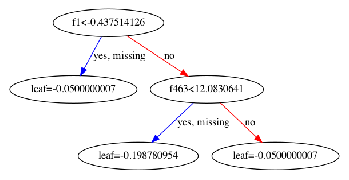

In [112]:
from xgboost import plot_tree
plot_tree(xgc)

# Conclusion

- In the current dataset, the predictions are not sufficient to fullfill the job. Even by translating the contactrequests task into a classification task, the models are still not able to converge decent. 